In [32]:
import pandas as pd
import numpy as np
import os
import pickle
from pandas.api.types import is_string_dtype, is_numeric_dtype
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [33]:
cwd = os.getcwd()
dataPath1 = cwd + '\\data\\train.csv'
dataPath2 = cwd + '\\data\\test.csv'
df1 = pd.read_csv(dataPath1)
df2 = pd.read_csv(dataPath2)

In [34]:
# Remove rows with missing target and separate target from predictors
df1.dropna(axis=0, subset=['SalePrice'], inplace=True)
y = df1.SalePrice
df1.drop(['SalePrice'], axis=1, inplace=True)

# Split into validation and training data
train_X, val_X, train_y, val_y = train_test_split(df1, y, shuffle=True, train_size=0.85, test_size=0.15, random_state=1)

In [35]:
# Select categorical columns with relatively low cardinality
categorical_cols = [cname for cname in train_X.columns if train_X[cname].nunique() < 10 and train_X[cname].dtype == "object"]

# Select numerical columns
numerical_cols = [cname for cname in train_X.columns if train_X[cname].dtype in ['int64', 'float64']]

# Keep selected columns only
working_cols = categorical_cols + numerical_cols
X_train = train_X[working_cols].copy()
y_train = train_y.copy()
X_val = val_X[working_cols].copy()
y_val = val_y.copy()
X_test = df2[working_cols].copy()

<AxesSubplot:>

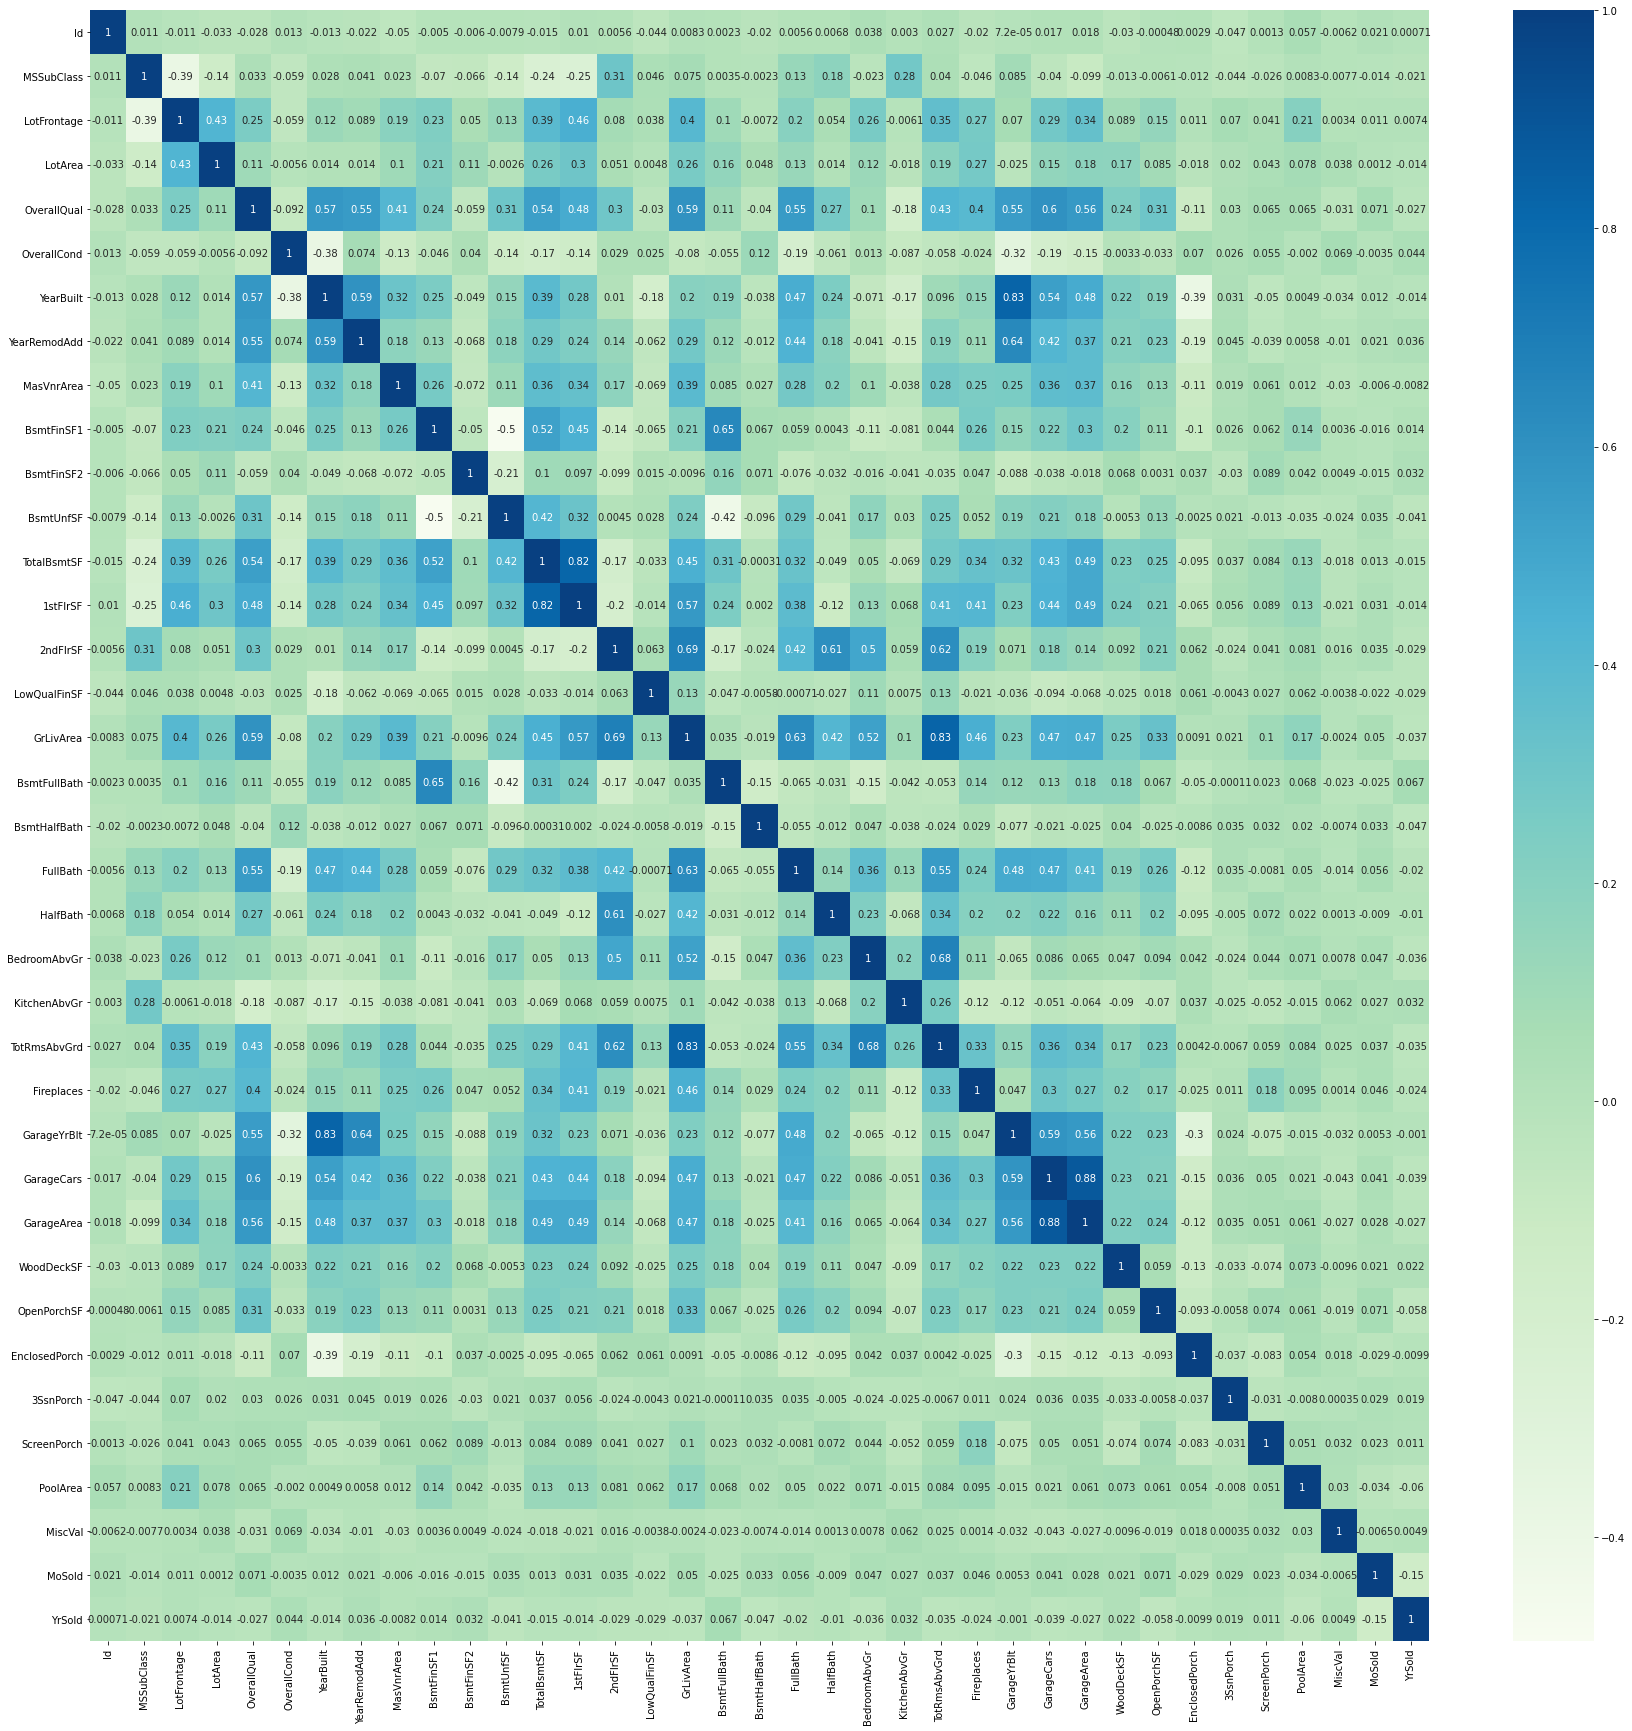

In [36]:
plt.figure(figsize = (30, 30))
correlation = df1.corr()
sns.heatmap(correlation, cmap = 'GnBu', annot = True)

In [37]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_cols),
    ('cat', categorical_transformer, categorical_cols)
])

In [38]:
def get_score(n_estimators):
    # Define model
    model = RandomForestRegressor(n_estimators, random_state=0)
    
    # Bundle preprocessing and modeling code in a pipeline
    clf = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    # Multiply by -1 since sklearn calculates *negative* MAE
    scores = -1 * cross_val_score(clf, X_train, y_train, cv=3, scoring='neg_mean_absolute_error')
    return scores.mean()

In [39]:
results = {}
for i in range(1, 9):
    results[i * 50] = get_score(i * 50)

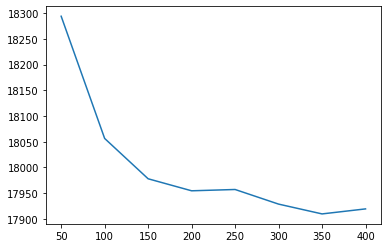

In [40]:
plt.plot(list(results.keys()), list(results.values()))
plt.show()

In [41]:
# Define model
model = RandomForestRegressor(n_estimators=350, random_state=0)

# Bundle preprocessing and modeling code in a pipeline
clf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', model)
])

# Preprocessing of training data, fit model 
clf.fit(X_train, y_train)

# Preprocessing of validation data, get predictions
preds = clf.predict(X_val)

print('MAE: {:,.3f}'.format(mean_absolute_error(y_val, preds)))

MAE: 15,227.578


In [42]:
# Access the current working directory and output the model to a pickle file
cwd = os.getcwd()
modelPath = os.path.join(cwd,'model', 'rf_housing_pipeline.pkl')
with open(modelPath, 'wb') as file:
	pickle.dump(model, file)

In [43]:
# make predictions using the test data file
preds_test = clf.predict(X_test)
print(preds_test)

[125993.56571429 153139.14285714 179388.17714286 ... 152509.54285714
 113376.33142857 228047.68857143]


In [44]:
# Save predictions to a file
output = pd.DataFrame({'Id': df2.Id, 'SalePrice': preds_test})
output.to_csv('data\\submission.csv', index=False)